### Testing the XY-axis direction on the T7 behavioural setup
On 2025-04-09, Tihana & Sharbat performed an experiment at the T7 behavioural setup in the behavioural room (2061).

Two objects (a pair of tweezers and a permanent marker) are placed along two axes of the platform.

A photograph of what it looks like physically (via Sharbat's phone camera is given below)

In [9]:
import os
import pandas as pd
from matplotlib import cm 
import matplotlib.pyplot as plt 
from scipy import stats
import numpy as np
import src.parse_data as anm_parse
import src.plot_data as anm_plot
from matplotlib import animation
plt.style.use('../anemotaxis.mplstyle')
from IPython.display import display
import ipywidgets as widgets

In [10]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data_folder = "/Users/sharbat/Projects/20250409_162408/"
columns = ["time","x", "y"]
larvae_data = anm_parse.extract_all_larvae(data_folder, columns)

In [12]:
from pprint import pprint
larva_id = 'test01'  # Example larva ID
# Accessing metadata, data, and summary for larva
pprint(larvae_data[larva_id]["metadata"])  # Experiment details
pprint(larvae_data[larva_id]["summary"])   # Summary statistics

{'date': '20240219_140808',
 'effector': 'test',
 'genotype': 'test',
 'raw_protocol': 'none#n#n#n',
 'stimulus_type': 'none#n#n#n',
 'tracker': 't7'}
{'time': {'max': np.float64(30.137),
          'mean': np.float64(14.267793733681463),
          'min': np.float64(0.006),
          'size': 383},
 'x': {'max': np.float64(60.947),
       'mean': np.float64(57.220684073107044),
       'min': np.float64(53.427),
       'size': 383},
 'y': {'max': np.float64(155.391),
       'mean': np.float64(152.02590600522194),
       'min': np.float64(149.433),
       'size': 383}}


In [13]:
def plot_trajectory_over_time(data, larva_id):
    """Plot larva trajectory with interactive time slider."""
    plt.ioff()
    
    # Get data
    larva = data[larva_id]['data']
    time = np.array(larva['time'])
    x = np.array(larva['x'])
    y = np.array(larva['y'])
    
    # Create figure and initialize plot
    fig, ax = plt.subplots(figsize=(8, 8))
    point, = ax.plot([], [], 'o', color='blue', markersize=10)
    
    # Set axis limits with padding
    x_padding = (np.max(x) - np.min(x)) * 0.1
    y_padding = (np.max(y) - np.min(y)) * 0.1
    ax.set_xlim(np.min(x) - x_padding, np.max(x) + x_padding)
    ax.set_ylim(np.min(y) - y_padding, np.max(y) + y_padding)
    
    # Plot full trajectory as background
    ax.plot(x, y, '-', color='gray', alpha=0.3, linewidth=1)
    
    def update(frame):
        # Update point position
        point.set_data([x[frame]], [y[frame]])
        ax.set_title(f'Time: {time[frame]:.2f}s')
        return (point,)
    
    # Create interactive controls
    play = widgets.Play(
        value=0,
        min=0,
        max=len(time) - 1,
        step=1,
        interval=50,
        description="Play"
    )
    
    slider = widgets.IntSlider(
        min=0,
        max=len(time) - 1,
        description='Frame:',
        value=0,
        style={'description_width': 'initial'},
        readout_format='d',
        layout=widgets.Layout(width='1000px')
    )
    
    # Link play and slider
    widgets.jslink((play, 'value'), (slider, 'value'))
    
    def update_plot(change):
        if change['type'] == 'change' and change['name'] == 'value':
            update(change['new'])
            fig.canvas.draw_idle()
    
    # Set axes properties
    ax.set_aspect('equal')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True, alpha=0.3)
    
    # Connect events
    slider.observe(update_plot)
    
    # Display controls and figure
    display(widgets.HBox([play, slider]))
    display(fig.canvas)
    
    # Initialize plot
    update_plot({'type': 'change', 'name': 'value', 'new': 0})
    
    plt.tight_layout()

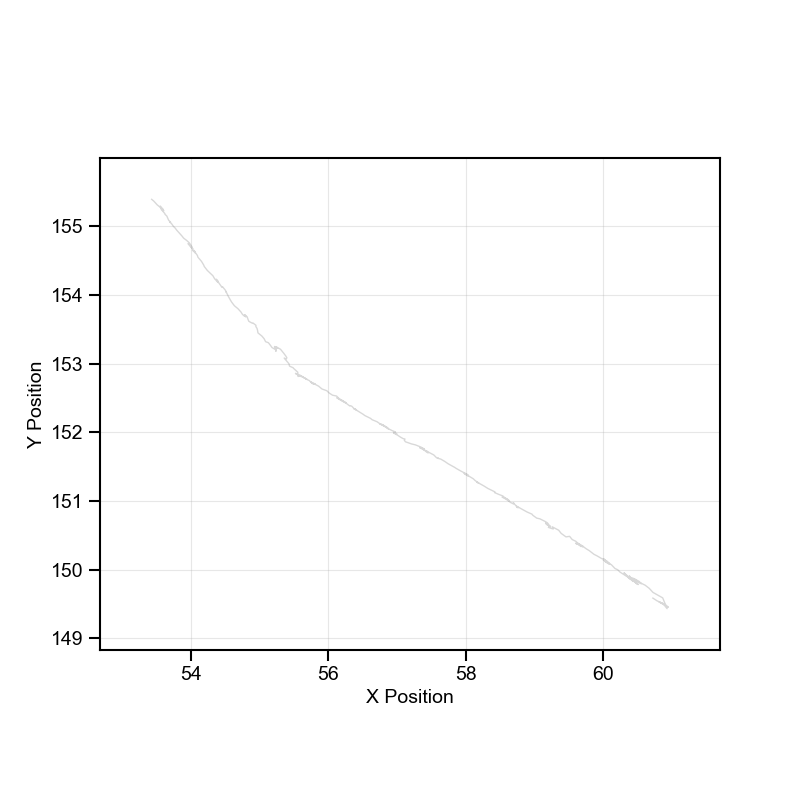

In [14]:
# Display interactive plot
plot_trajectory_over_time(larvae_data, larva_id)